## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [54]:
# Obtener las imagen 'histo_x.jpg'

In [55]:
# Implementamos el acceso a los .jpg de manera comoda.
import requests
# URL directa a la imagen en bruto
image_url1 = "https://raw.githubusercontent.com/JLRRC/MASTERIA/main/05MIAR_Aprendizaje_Supervisado/Act/histo_1.jpg"
output_path1 = "histo_1.jpg"  # Nombre para guardar la imagen localmente
image_url2 = "https://raw.githubusercontent.com/JLRRC/MASTERIA/main/05MIAR_Aprendizaje_Supervisado/Act/histo_2.jpg"
output_path2 = "histo_2.jpg"  # Nombre para guardar la imagen localmente

# Descargar la imagen1
response = requests.get(image_url1)
if response.status_code == 200:
    with open(output_path1, "wb") as file:
        file.write(response.content)
    print(f"Imagen descargada exitosamente como: {output_path1}")
else:
    print(f"Error al descargar la imagen. Código de estado: {response.status_code}")

# Descargar la imagen2
response = requests.get(image_url2)
if response.status_code == 200:
    with open(output_path2, "wb") as file:
        file.write(response.content)
    print(f"Imagen descargada exitosamente como: {output_path2}")
else:
    print(f"Error al descargar la imagen. Código de estado: {response.status_code}")

Imagen descargada exitosamente como: histo_1.jpg
Imagen descargada exitosamente como: histo_2.jpg


# **SECCIÓN 01 - Para la imagen histo_1.jpg**

In [102]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

In [105]:
# Importar las librerías necesarias; skimage y matplotlib
from skimage import io, filters, img_as_ubyte, color
from skimage.filters import gaussian, threshold_otsu
import matplotlib.pyplot as plt

# Leer la imagen en formato RGB
image_path = "histo_1.jpg"
image = io.imread(image_path)

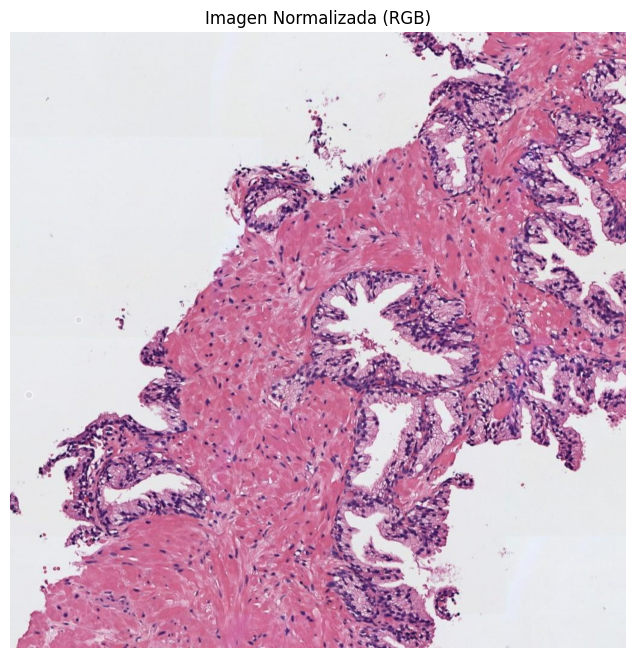

In [103]:
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
image_normalized = image / 255.0

# Visualizar la imagen
plt.figure(figsize=(8, 8))
plt.imshow(image_normalized)
plt.title("Imagen Normalizada (RGB)")
plt.axis("off")
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [83]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

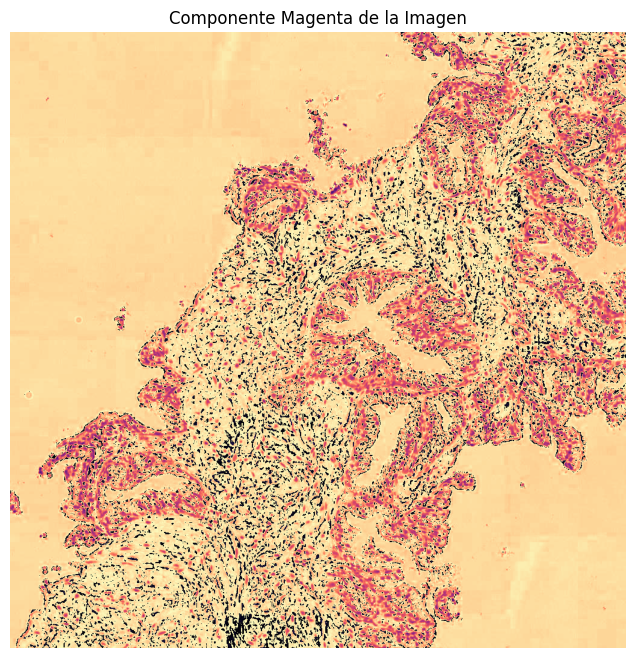

In [104]:
# Extraer la componente magenta
# Separar los canales RGB
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Calcular la componente magenta
magenta_component = np.maximum(red_channel + blue_channel - green_channel, 0)

# Normalizar la componente magenta para visualizarla mejor (opcional)
magenta_normalized = magenta_component / magenta_component.max()

# Visualizar la imagen normalizada del canal magenta
plt.figure(figsize=(8, 8))
plt.imshow(magenta_normalized, cmap='magma')
plt.title("Componente Magenta de la Imagen")
plt.axis("off")
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [67]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

Umbral calculado por Otsu: 201


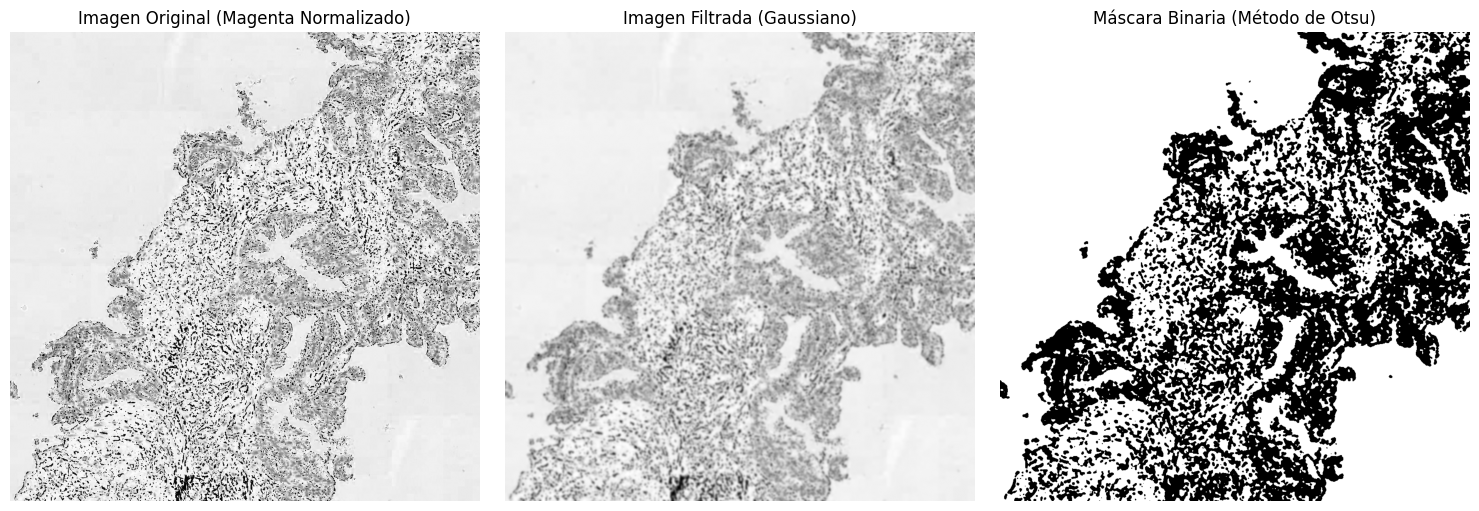

In [106]:
# Aplicar un filtro gaussiano (suavizado) con un tamaño 5x5 (aproximadamente sigma=2) a magenta_normalized (la región tisular)
gaussian_filtered = gaussian(magenta_normalized, sigma=2, mode='reflect')

# Convertir la imagen al rango [0, 255] y formato uint8
gaussian_filtered_uint8 = img_as_ubyte(gaussian_filtered)

# Aplicar el método de Otsu para obtener el umbral óptimo
otsu_threshold = threshold_otsu(gaussian_filtered_uint8)
print(f"Umbral calculado por Otsu: {otsu_threshold}")

# Crear la máscara binaria: píxeles mayores o iguales al umbral son 1, el resto es 0
binary_mask = gaussian_filtered_uint8 >= otsu_threshold

# Visualizar la imagen original, la imagen filtrada y la máscara binaria
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
ax[0].imshow(magenta_normalized, cmap='gray')
ax[0].set_title("Imagen Original (Magenta Normalizado)")
ax[0].axis("off")

# Imagen con filtro Gaussiano
ax[1].imshow(gaussian_filtered, cmap='gray')
ax[1].set_title("Imagen Filtrada (Gaussiano)")
ax[1].axis("off")

# Máscara binaria
ax[2].imshow(binary_mask, cmap='gray')
ax[2].set_title("Máscara Binaria (Método de Otsu)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [93]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

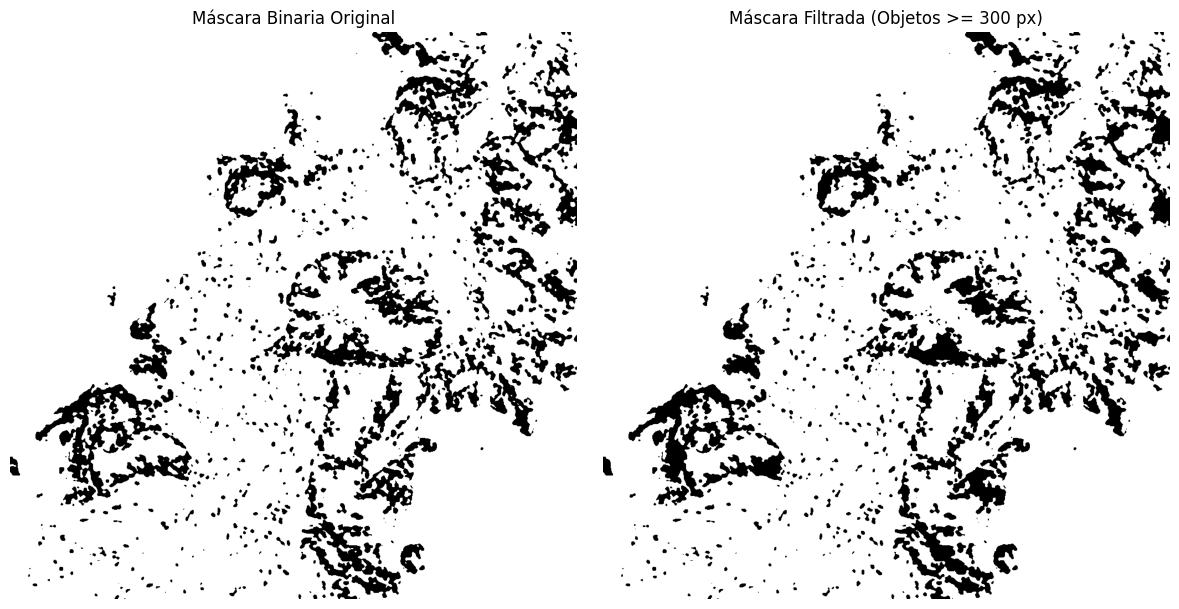

In [94]:
# Eliminar objetos pequeños (área menor a 300 píxeles), usamos la "mascata binaria"
filtered_mask = morphology.remove_small_objects(binary_mask, min_size=300)

# Visualizar la máscara original y la máscara filtrada
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(binary_mask, cmap="gray")
ax[0].set_title("Máscara Binaria Original")
ax[0].axis("off")

ax[1].imshow(filtered_mask, cmap="gray")
ax[1].set_title("Máscara Filtrada (Objetos >= 300 px)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [19]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

Semillas encontradas automáticamente: [(508, 492), (132, 1008)]


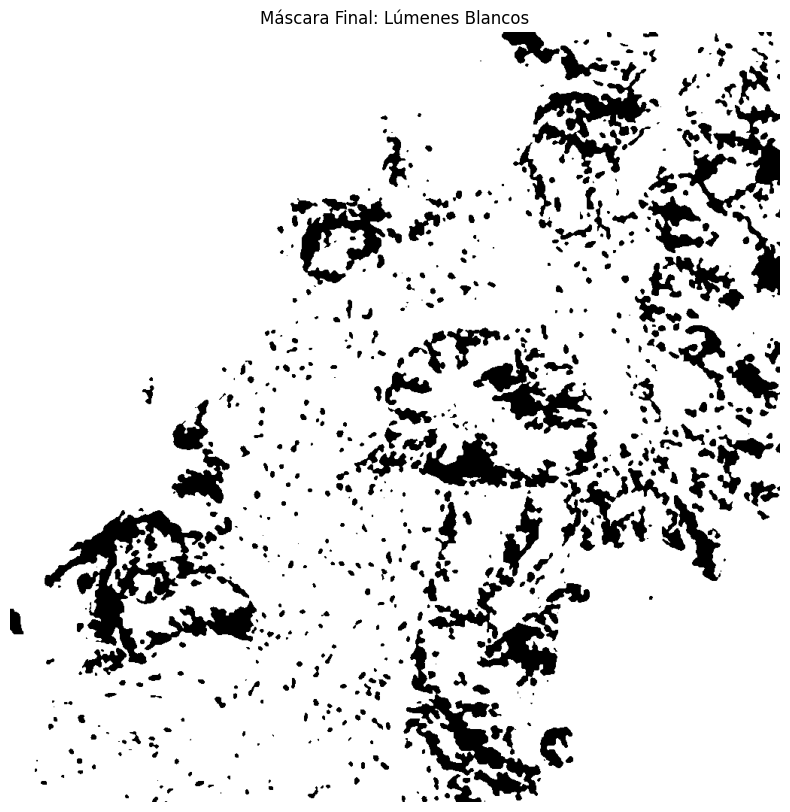

In [109]:
import numpy as np
from skimage import measure
from skimage.segmentation import flood
import matplotlib.pyplot as plt

# Asegúrate de que filtered_mask sea binaria (True/False)
filtered_mask = filtered_mask.astype(bool)

# Función para encontrar semillas automáticamente
def find_seeds(mask, num_seeds=2):
    """
    Encuentra semillas automáticamente basándose en las regiones más grandes.
    Args:
        mask: Máscara binaria de entrada.
        num_seeds: Número de semillas a encontrar.
    Returns:
        Lista de coordenadas (fila, columna) de las semillas.
    """
    labeled_mask = measure.label(mask)  # Etiquetar las regiones conectadas
    regions = measure.regionprops(labeled_mask)
    # Seleccionar las regiones más grandes como semillas
    seeds = [tuple(map(int, region.centroid)) for region in sorted(regions, key=lambda r: -r.area)[:num_seeds]]
    return seeds

# Encontrar semillas automáticamente en la máscara
seeds = find_seeds(filtered_mask, num_seeds=2)
print(f"Semillas encontradas automáticamente: {seeds}")

# Alternativamente, puedes definir semillas manualmente:
# seeds = [(100, 150), (300, 250)]  # Coordenadas ejemplo

# Aplicar el algoritmo de crecimiento de región
def apply_region_growing(mask, seeds):
    """
    Aplica el crecimiento de región a partir de las semillas dadas.
    Args:
        mask: Máscara binaria de entrada.
        seeds: Lista de coordenadas de las semillas.
    Returns:
        Máscara binaria con las regiones crecidas.
    """
    region_mask = np.zeros_like(mask, dtype=bool)
    for seed in seeds:
        region = flood(mask, seed_point=seed)
        region_mask |= region  # Combinar las regiones crecidas
    return region_mask

# Crear la máscara final con crecimiento de región
region_mask = apply_region_growing(filtered_mask, seeds)

# Visualizar la máscara resultante
plt.figure(figsize=(10, 10))
plt.imshow(region_mask, cmap='gray')
plt.title("Máscara Final: Lúmenes Blancos")
plt.axis("off")
plt.show()

#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

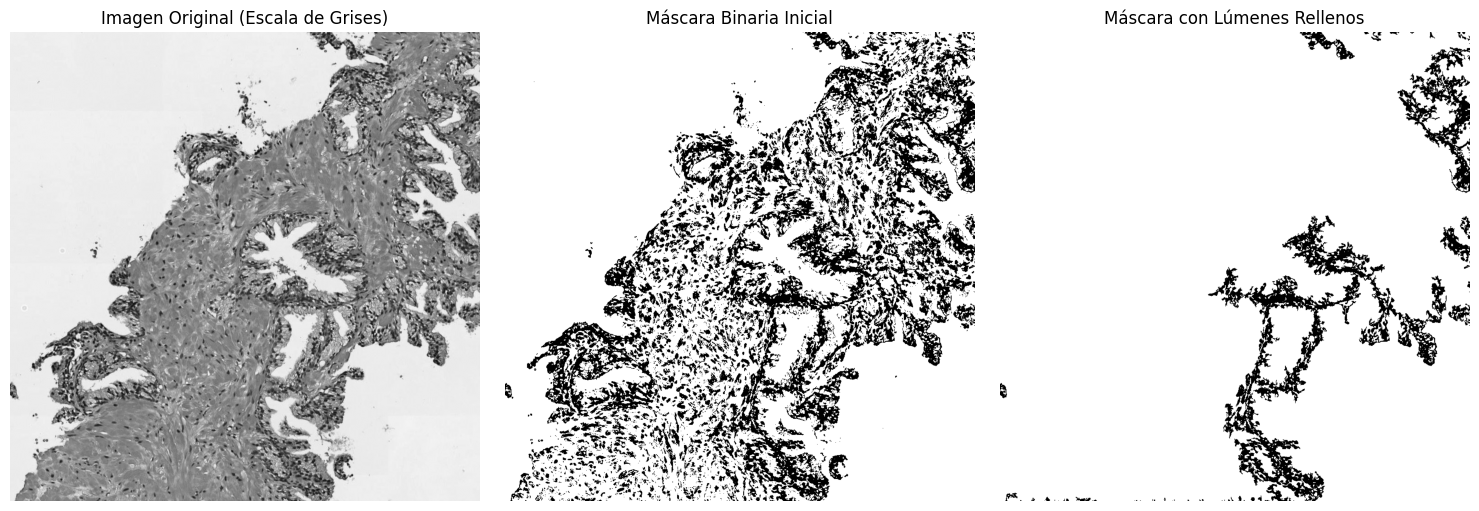

In [73]:
# Rellenar los huecos en los lúmenes
filled_mask = binary_fill_holes(binary_mask)

# Visualizar los resultados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(grayscale_image, cmap="gray")
ax[0].set_title("Imagen Original (Escala de Grises)")
ax[0].axis("off")

ax[1].imshow(binary_mask, cmap="gray")
ax[1].set_title("Máscara Binaria Inicial")
ax[1].axis("off")

ax[2].imshow(filled_mask, cmap="gray")
ax[2].set_title("Máscara con Lúmenes Rellenos")
ax[2].axis("off")

plt.tight_layout()
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

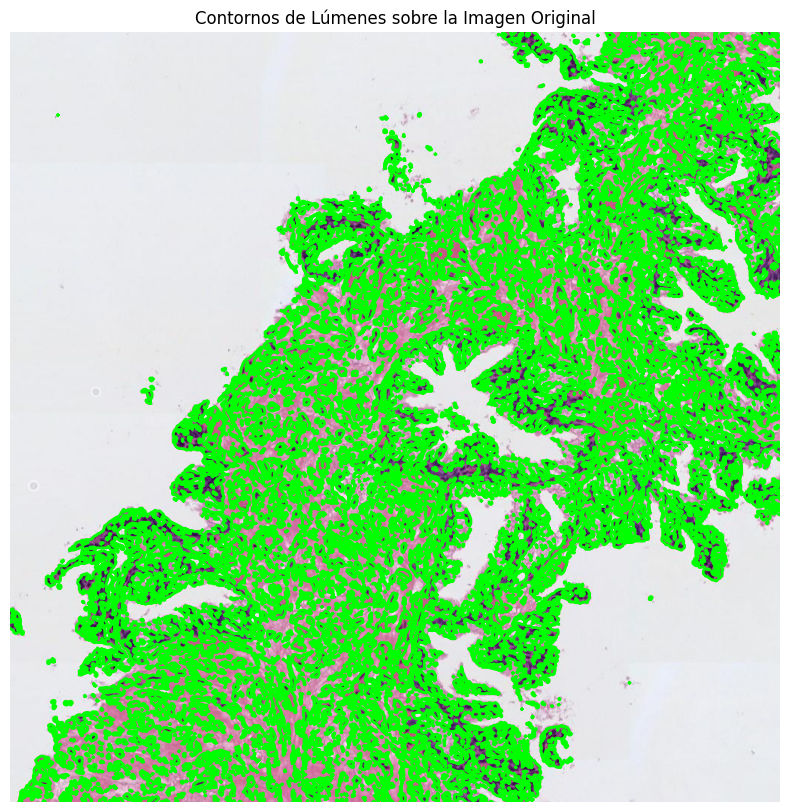

In [74]:
# Encontrar los contornos en la máscara binaria
contours = measure.find_contours(binary_mask, level=0.5)

# Dibujar los contornos sobre la imagen original
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_rgb)

# Dibujar cada contorno en verde
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='lime')

# Configuración de la visualización
ax.set_title("Contornos de Lúmenes sobre la Imagen Original")
ax.axis("off")
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

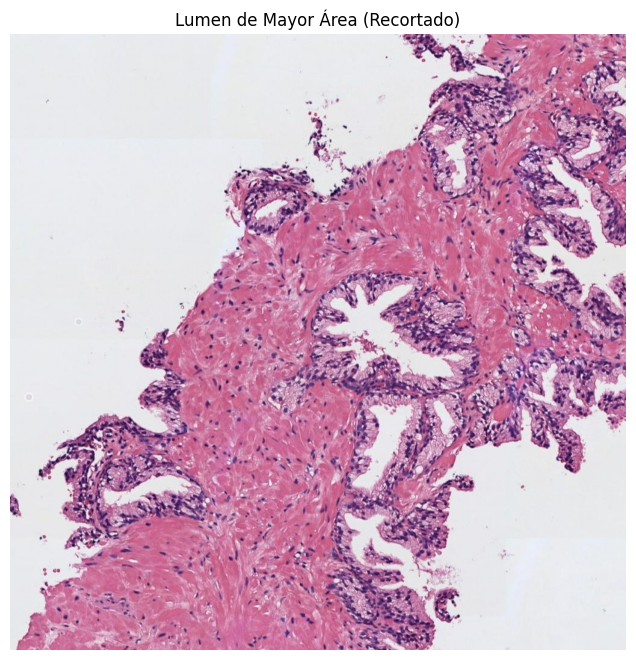

In [75]:
# Eliminar objetos pequeños (opcional, ajusta el tamaño mínimo si es necesario)
binary_mask = morphology.remove_small_objects(binary_mask, min_size=300)

# Etiquetar las regiones conectadas en la máscara binaria
labeled_mask = measure.label(binary_mask, connectivity=2)

# Calcular las propiedades de las regiones etiquetadas
regions = measure.regionprops(labeled_mask)

# Verificar si se encontraron regiones
if len(regions) == 0:
    print("No se encontraron regiones en la máscara binaria.")
else:
    # Encontrar el lumen con el área más grande
    largest_region = max(regions, key=lambda r: r.area)

    # Extraer las coordenadas del bounding box (caja delimitadora) del lumen más grande
    minr, minc, maxr, maxc = largest_region.bbox

    # Recortar el lumen más grande de la imagen original RGB
    cropped_lumen = image_rgb[minr:maxr, minc:maxc]

    # Visualizar el lumen cropeado
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_lumen)
    plt.title("Lumen de Mayor Área (Recortado)")
    plt.axis("off")
    plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [76]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [77]:
# Verificar si se encontraron regiones
if len(regions) == 0:
    print("No se encontraron regiones en la máscara binaria.")
else:
    # Encontrar el lumen con el área más grande
    largest_region = max(regions, key=lambda r: r.area)

    # Características del lumen de mayor área
    area = largest_region.area
    bounding_box_area = (largest_region.bbox[2] - largest_region.bbox[0]) * (largest_region.bbox[3] - largest_region.bbox[1])
    convex_area = largest_region.convex_area
    eccentricity = largest_region.eccentricity
    equivalent_diameter = largest_region.equivalent_diameter
    extent = largest_region.extent
    feret_diameter = max(largest_region.major_axis_length, largest_region.minor_axis_length)
    major_axis_length = largest_region.major_axis_length
    minor_axis_length = largest_region.minor_axis_length
    orientation = largest_region.orientation
    perimeter = largest_region.perimeter
    solidity = largest_region.solidity

    # Compacidad = (Perímetro^2) / (4 * π * Área)
    compactness = (perimeter ** 2) / (4 * np.pi * area)

    # Mostrar resultados redondeados a 4 decimales
    print("Características del Lumen de Mayor Área:")
    print(f"1) Área: {round(area, 4)}")
    print(f"2) Área de la Bounding Box: {round(bounding_box_area, 4)}")
    print(f"3) Área Convexa: {round(convex_area, 4)}")
    print(f"4) Excentricidad: {round(eccentricity, 4)}")
    print(f"5) Diámetro Equivalente: {round(equivalent_diameter, 4)}")
    print(f"6) Extensión: {round(extent, 4)}")
    print(f"7) Diámetro Feret: {round(feret_diameter, 4)}")
    print(f"8) Longitud del Eje Mayor: {round(major_axis_length, 4)}")
    print(f"9) Longitud del Eje Menor: {round(minor_axis_length, 4)}")
    print(f"10) Orientación: {round(orientation, 4)}")
    print(f"11) Perímetro: {round(perimeter, 4)}")
    print(f"12) Solidez: {round(solidity, 4)}")
    print(f"13) Compacidad: {round(compactness, 4)}")

Características del Lumen de Mayor Área:
1) Área: 777631.0
2) Área de la Bounding Box: 1048576
3) Área Convexa: 1048576.0
4) Excentricidad: 0.4854
5) Diámetro Equivalente: 995.043
6) Extensión: 0.7416
7) Diámetro Feret: 1287.2246
8) Longitud del Eje Mayor: 1287.2246
9) Longitud del Eje Menor: 1125.3943
10) Orientación: 0.739
11) Perímetro: 108007.7599
12) Solidez: 0.7416
13) Compacidad: 1193.786
